# 基于MindSpore框架的SGD优化器案例实现

## 1 SGD优化器基本原理讲解
随机梯度下降（SGD）是一种迭代方法，其背后基本思想最早可以追溯到1950年代的Robbins-Monro算法，用于优化可微分目标函数。

它可以被视为梯度下降优化的随机近似，因为它用实际梯度（从整个数据集计算）替换为实际梯度（从随机选择的数据子集计算）。特别是在高维优化问题中，这减少了非常高的计算负担，实现更快的迭代以换取更低的收敛速度。随机梯度下降已成为机器学习中重要的优化方法。

### 1.1 梯度下降（Gradient Descent）
梯度表示某一函数在该点处的方向导数沿着该方向取得最大值，即函数在该点处沿着该方向（此梯度的方向）变化最快，变化率最大（为该梯度的模）。

在机器学习中，每个学习模型都有损失函数，用来衡量机器学习模型的精确度。一般来说，损失函数的值越小，模型的精确度就越高。梯度下降的目的，就是为了更快地最小化损失函数。

举个例子，假设损失函数为$$f(\omega)=0.5\omega^2+\omega+6$$在A点，切线为g，切点A的梯度为切线向下方向，此时选择一个学习率AC（用$\alpha$表示），使得权重值$$\omega_{i+1}=\omega_i-\alpha * \frac {dF}{d\omega}$$,迭代多次直至函数值收敛不变，即为损失率的最低点。

![avatar](image/1.png)

但是对于多维高次函数，梯度下降算法只能在局部找到最优解，但是不一定能找到全局最优解；并且传统的梯度下降很容易出现过拟合的情况。

![avatar](image/2.png)
<div align='center'><font size='1'>复杂函数的梯度</font></div>

### 1.2 随机梯度下降（SGD）
标准的梯度下降主要有两大缺点，一是训练过程及其缓慢，二是容易陷入局部最优解。

于是需要随机梯度下降算法。

在梯度下降的基础上，随机梯度下降从样本中随机抽出一组样本，训练后按梯度更新一次，然后再抽取一组样本更新一次。在样本量极其大的情况下，可能不用训练完所有的样本就可以获得一个损失值在可接受范围之内的模型。
假设损失函数为:$$J(\theta)=\frac12\sum_1^m(h_\theta(x)-y)^2$$其中$h_\theta(x)=\theta_0+\theta_1x_1\theta_2x_2+…+\theta_nx_n$

梯度下降：$\theta_{j+1}=\theta_j-\alpha\frac{\partial{J(\theta)}}{\partial\theta_j}$

$\frac{\partial{J(\theta)}}{\partial\theta_j}=\frac{\partial{\frac12(h_\theta(x)-y)^2}}{\partial\theta_j}$

$=(h_\theta(x)-y)·\frac{\partial(h_\theta(x)-y)}{\partial\theta_j}$

$=(h_\theta(x)-y)·\frac{\partial(\sum_{i=0}^n(\theta_ix_i-y)}{\partial\theta_j}$

$=(h_\theta(x)-y)x_j$

随机梯度下降算法每次抽取一个样本点i,根据样本值计算梯度下降的方向，并更新权重，即：$$\theta_{j+1}=\theta_j-\alpha(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}$$
这样函数不会完全根据自身梯度方向进行前进，在一定程度上避免了落入局部最优解；并且在很大程度上降低了数据训练时间。

根据算法原理，用代码简单搭建了一个随机梯度下降算法的优化器：


In [11]:
import numpy as np
def SGD(data_x, data_y, alpha=0.1, maxepochs=10000,epsilon=1e-4):
    xMat = np.mat(data_x)
    yMat = np.mat(data_y)
    m, n = xMat.shape
    weights = np.ones((n, 1))  # 模型参数
    epochs_count = 0
    loss_list = []
    epochs_list = []
    while epochs_count < maxepochs:
        rand_i = np.random.randint(m)  # 随机取一个样本
        loss = cost(xMat,weights,yMat) #前一次迭代的损失值
        hypothesis = sigmoid(np.dot(xMat[rand_i,:],weights)) #预测值
        error = hypothesis -yMat[rand_i,:] #预测值与实际值误差
        grad = np.dot(xMat[rand_i,:].T,error) #损失函数的梯度
        weights = weights - alpha*grad #参数更新
        loss_new = cost(xMat,weights,yMat)#当前迭代的损失值
        print(loss_new)
        if abs(loss_new-loss)<epsilon:
            break
        loss_list.append(loss_new)
        epochs_list.append(epochs_count)
        epochs_count += 1
    print('迭代到第{}次，结束迭代！'.format(epochs_count))
    plt.plot(epochs_list,loss_list)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    return weights

在此段代码中，算法首先初始化所有参数，并且定义了损失链表和迭代链表。在每一次迭代的过程中，算法随机选取一个样本点，计算梯度，并根据$weights = weights-\alpha* grad$（$\alpha$为学习率，grad为梯度）权重值，并记录每一次的损失值loss_new和迭代次数，当损失值小于某个阈值时（即$\epsilon$）可以认为该点即为当前函数损失的最小值。

标准的随机梯度下降算法在每次参数更新时，仅仅选取一个样本计算梯度，用一个样本的梯度代替全部样本的梯度，能够大大加快训练速度。此外，由于每次迭代并不是都向着整体最优化方向，导致梯度下降的波动非常大，更容易从一个局部最优跳到另一个局部最优，但无法根本上解决局部最优问题。

我们通常所采用的SGD优化器，其实都采用Mini-batch Gradient Descent（小批量梯度下降法），我们熟悉的参数batch便应用于此。本质上是用一批样本的梯度代替全部样本的梯度。通常批大小选择2的倍数，方便计算机处理。这里假设批大小为m。

$$\theta_{j+1}=\theta_j-\alpha\frac 1m\sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}$$

这种做好的好处是可以降低参数更新时的方差，收敛更稳定，另一方面可以充分地利用深度学习库中高度优化的矩阵操作来进行更有效的梯度计算。

### 1.3 SGD算法的几个问题
1.受抽取训练样本的影响较大。\
2.没有解决梯度消失和梯度爆炸的情况。\
3.无法处理过拟合的情况。\
4.不能保证很好的收敛性。

## 2 基于MindSpore框架源码的SGD优化方法讲解

### 2.1 源码及优化方法

首先查找MindSpore官方文档，找到SGD优化器的API文档。
网址：https://www.mindspore.cn/docs/zh-CN/r1.9/api_python/nn/mindspore.nn.SGD.html#mindspore.nn.SGD

In [ ]:
from mindspore.ops import functional as F, composite as C, operations as P
from mindspore.common.parameter import Parameter
from mindspore.common.tensor import Tensor
import mindspore.common.dtype as mstype
from mindspore._checkparam import Validator as validator
from .optimizer import Optimizer
from .optimizer import opt_init_args_register

_sgd_opt = C.MultitypeFuncGraph("sgd_opt")


@_sgd_opt.register("Function", "Tensor", "Tensor", "Tensor", "Tensor", "Tensor", "Tensor")
def _tensor_run_opt_ext(opt, momentum, learning_rate, gradient, weight, accum, stat):
    """Apply sgd optimizer to the weight parameter using Tensor."""
    success = True
    success = F.depend(success, opt(weight, gradient, learning_rate, accum, momentum, stat))
    return success


class SGD(Optimizer):
    @opt_init_args_register
    def __init__(self, params, learning_rate=0.1, momentum=0.0, dampening=0.0, weight_decay=0.0, nesterov=False,
                 loss_scale=1.0):

        super(SGD, self).__init__(learning_rate, params, weight_decay, loss_scale)

        if isinstance(momentum, int):
            momentum = float(momentum)
        if not isinstance(momentum, float):
            raise TypeError("For 'SGD', the argument 'momentum' should be float type, "
                            "but got {}.".format(type(momentum)))

        if isinstance(momentum, float) and momentum < 0.0:
            raise ValueError("For 'SGD', the argument 'momentum' should be at least 0.0, "
                             "but got {}".format(momentum))

        if isinstance(dampening, int):
            dampening = float(dampening)
        if not isinstance(dampening, float):
            raise TypeError("For 'SGD', the argument 'dampening' should be float type, "
                            "but got {}.".format(type(dampening)))

        if dampening < 0.0:
            raise ValueError("For 'SGD', the argument 'dampening' should be at least 0.0, "
                             "but got 'dampening' {}".format(dampening))
        self.dampening = dampening

        if isinstance(weight_decay, int):
            weight_decay = float(weight_decay)

        validator.check_value_type("nesterov", nesterov, [bool], self.cls_name)

        if nesterov and (momentum <= 0.0 or dampening != 0.0):
            raise ValueError("For 'SGD', if 'nesterov' is true, 'momentum' must be > 0.0 and 'dampening' must "
                             "equal to 0.0, but got 'momentum' {}, 'dampening' {}".format(momentum, dampening))
        self.nesterov = nesterov

        self.opt = P.SGD(dampening, weight_decay, nesterov)

        self.momentum = Parameter(Tensor(momentum, mstype.float32), name="momentum")
        self.accum = self.parameters.clone(prefix="accum", init='zeros')
        self.stat = self.parameters.clone(prefix="stat", init='ones')

    def construct(self, gradients):
        params = self.parameters
        accum = self.accum
        stat = self.stat
        gradients = self.gradients_centralization(gradients)
        gradients = self.scale_grad(gradients)
        lr = self.get_lr()
        if self.is_group_lr:
            success = self.hyper_map_reverse(F.partial(_sgd_opt, self.opt, self.momentum),
                                             lr, gradients, params, accum, stat)
        else:
            success = self.hyper_map_reverse(F.partial(_sgd_opt, self.opt, self.momentum, lr),
                                             gradients, params, accum, stat)
        return success

根据以上源码以及API文档，我们发现MindSpore对SGD优化器已经使用了不少优化方法，有momentum,dampening,nesterov,weight-decay,gradients_centralization等。我们一一讲解。

### 2.2 momentum

理论依据：momentum算法在原有的梯度下降法中引入了动量，主要为了是解决梯度消失带来的问题。

momentum的思想也很简单：参数更新时在一定程度上保留之前更新的方向，同时又利用当前batch的梯度微调最终的更新方向，简言之就是通过积累之前的动量来加速当前的梯度。

假设$v_i$表示i时刻的动量，$g_t$为i时刻的梯度。原始的$v_i$计算是将$v_{i-1}$和$g_t$直接相加，当发生梯度消失时，$v_i$和$v_{i-1}$就变得一样，引入动量因子momentum使得$v_i$从$v_{i-1}$和$g_t$的直接相加变成了$$v_i=v_{i-1}* momentum+g_t$$\
权重值更新：$$\omega_i=\omega_{i-1}-\alpha*v_i$$
当梯度消失时，有动量因子momentum的存在使得$v_i$保持了$v_{i-1}$一定的惯性，从而减缓梯度消失带来的影响。

代码分析：从上述代码中可以看出，若当前迭代已经实例化momentum时（此时momentum为int类型），将momentum参数变成float类型，若当前迭代还没有实例化momentum，则生成当前迭代的momentum，检查momentum是否合理（是否是大于0的float类型），若没有问题，则将参数传入到SGD算法中。

算法优点：当某个参数在最近一段时间内的梯度方向不一致时，其真实的参数更新幅度变小；相反，当在最近一段时间内的梯度方向都一致时，其真实的参数更新幅度变大，起到加速作用。

### 2.3 dampening

理论依据：与momentum原理相似，当损失函数的出现梯度爆炸的情况时，函数的偏导值会变成∞，对于$v_i=v_{i-1}*momentum+g_t$，此时$v_i$受$g_t$的影响较大，从而使的$v_i$无法很好的获取当前的值，所以在偏导数$g_t$中引入参数dampening，使得$$v_i=v_{i-1}*momentum+g_t(1-dampening)$$
权重值更新：$$\omega_i=\omega_{i-1}-\alpha*v_i$$
从而减小梯度爆炸的影响。

代码分析：由上述代码，同momentum一样，若当前迭代已经实例化dampening时（此时dampening为int类型），将dampening参数变成float类型，若当前迭代还没有实例化dampening，则生成当前迭代的dampening（第一轮迭代更新时不起作用），检查dampening是否合理（是否是大于0的float类型），若没有问题，则将参数传入到SGD算法中。

算法优点：当某个参数的梯度出现极端情况时，dampening算法能够削弱当前参数的梯度的值。从而减缓梯度对真实参数的影响，主要是作用于梯度爆炸时的情况。

### 2.4 nesterov

理论依据：属于momentum算法的变种，与momentum唯一区别就是：计算梯度的不同。nesterov动量中，先用当前的速度$v_i$临时更新一遍参数，再用更新的临时参数计算梯度。因此，nesterov动量可以解释为在momentum动量方法中添加了一个校正因子。即$v_i=v_{i-1}*momentum+g_t(1-dampening)$

当nesterov为True时，$\omega_i=\omega_{i-1}-\alpha*(g_t+momentum*v_i)$\
当nesterov为False时，$\omega_i=\omega_{i-1}-\alpha*v_i$

代码分析：与理论描述一致，首先检查nesterov是否是bool值（True/False），然后直接将nesterov的值传入SGD算法中作为参数，若nesterov为True，则按照$\omega_i=\omega_{i-1}-\alpha*(g_t+momentum*v_i)$公式进行计算；否则按照$\omega_i=\omega_{i-1}-\alpha*v_i$进行计算。

### 2.5 weight-decay

理论依据：为了防止过拟合问题的出现，可以使用权值衰减做进一步的优化，即将$\theta_{j+1}=\theta_j-\alpha\frac{\partial{J(\theta)}}{\partial\theta_j}$变为$\theta_{j+1}=\theta_j-\alpha\frac{\partial{J(\theta)}}{\partial\theta_j}-wd*\alpha*\theta_j$，其中wd是权值衰减参数，增加了权值衰减项后，当计算过程中出现过拟合的情况下可以根据当前情况使用weight-decay Optimizer消除过拟合现象。在当前华为MindSpore框架中，在参数未分组时，优化器配置的 weight_decay 应用于名称不含“beta”或“gamma”的网络参数；参数分组情况下，可以分组调整权重衰减策略。

权值衰减的代码实现：

In [1]:
def decay_weight(self, gradients):
    if self.exec_weight_decay:
        params = self._parameters
        weight_decay = self.get_weight_decay()
        if self.is_group:
            gradients = self.map_(F.partial(_apply_decay), weight_decay, self.decay_flags, params, gradients)
        else:
            gradients = self.map_(F.partial(_apply_decay, weight_decay), self.decay_flags, params, gradients)

    return gradients

def get_weight_decay(self):
    if self.dynamic_weight_decay:
        if self.is_group:
            weight_decay = ()
            for weight_decay_, flag_ in zip(self.weight_decay, self.dynamic_decay_flags):
                current_weight_decay = weight_decay_(self.global_step) if flag_ else weight_decay_
                weight_decay += (current_weight_decay,)
            return weight_decay
        return self.weight_decay(self.global_step)
    return self.weight_decay

decay_weight函数首先调用get_weight_decay函数获取当前权重衰减的值，接着判断当前参数是否分组，若已经分组，则可以将weight_decay（权重衰减值）应用在所有网络中，即应用在所有数据集后续训练中；若已经分组，则要选择应用在指定的网络中（名称不含“beta”或“gamma”的网络），返回新的梯度。

get_weight_decay函数返回的是当前权重衰减的值，首先判断当前权重衰减值是否动态变化，若变化且当前数据向量已经分组，则循环将权重衰减值加上当前一轮迭代的权重衰减值，知道当前的权重衰减值不在总体训练集的衰减范围内，返回衰减值；若当前数据向量还未分组，则直接返回当前一轮迭代的权重衰减值；若当前权重衰减值已经不变（即已经收敛到最低点），则直接返回权重衰减值。

算法优点：在公式后边加上可训练的weight_decay参数，可以有效防止过拟合现象的出现。

### 2.6 Gradient Centralization（梯度中心化）

Gradient Centralization的思想由论文: Gradient Centralization: A New Optimization Technique for Deep Neural Networks提出，号称一行代码就能加速训练并提升准确率。Gradient Centralization的做法很简单：直接对梯度向量进行零均值化。Gradient Centralization能够加速网络训练，使网络的训练更加稳定，提高网络的泛化能力，并且能够轻松地嵌入各种优化器中。

下面以SGDM算法为例：

首先定义一些符号，$W$为权值矩阵，$w_i$为权值矩阵$W$的第i列，$\mathcal{L}$为目标函数，$\nabla_{W}\mathcal{L}$和$\nabla_{w_i}\mathcal{L}$为$\mathcal{L}$对$W$和$w_i$的梯度。

求权值矩阵每一列的均值
$$\mu\nabla_{w_i}\mathcal{L}=\frac 1M \sum_{j=1}^M\nabla_{w_{i,j}}\mathcal{L}$$

对权值矩阵进行零均值化
$$\Phi_{GC}(\nabla_{w_i}\mathcal{L})=\nabla_{w_i}\mathcal{L}-\mu\nabla_{w_i}\mathcal{L}$$




将Gradient Centralization嵌入到SGDM优化器中。

![avatar](image/GC.png)



回到源代码，根据API文档，在params参数中可以选择是否使用grad_centralization 。在SGD优化器的具体实现（construct函数）中，使用了grad_centralization。


In [ ]:
gradients = self.gradients_centralization(gradients)

### 2.7 如何使用SGD优化器
在实践中，我们需要调用MindSpore提供的SGD优化器接口，根据需要并查找文档，选取合适的参数。至于参数值，则需要用户自己慢慢调参了。这是官网给出的样例，可以参照这个初步了解优化器的用法。

In [ ]:
import mindspore as ms
from mindspore import nn

net = Net()
#1) All parameters use the same learning rate and weight decay
optim = nn.SGD(params=net.trainable_params())

#2) Use parameter groups and set different values
conv_params = list(filter(lambda x: 'conv' in x.name, net.trainable_params()))
no_conv_params = list(filter(lambda x: 'conv' not in x.name, net.trainable_params()))
group_params = [{'params': conv_params,'grad_centralization':True},
                {'params': no_conv_params, 'lr': 0.01},
                {'order_params': net.trainable_params()}]
optim = nn.SGD(group_params, learning_rate=0.1, weight_decay=0.0)
# The conv_params's parameters will use default learning rate of 0.1 and default weight decay of 0.0
# and grad centralization of True.
# The no_conv_params's parameters will use learning rate of 0.01 and default weight decay of 0.0 and grad
# centralization of False.
# The final parameters order in which the optimizer will be followed is the value of 'order_params'.

loss = nn.SoftmaxCrossEntropyWithLogits()
model = ms.Model(net, loss_fn=loss, optimizer=optim)

## 3 SGD应用案例

以上介绍了SGD以及它的很多优化方法，但如何选择优化方法和对应的参数依然是一个问题。

本部分我们希望通过一个案例设计一组对比实验，演示如何在实践中使用SGD优化器。通过这个案例，我们希望能达成三个目的:一是能够快速入门MindSpore，并将其应用于实践；二是掌握MindSpore框架SGD优化器的使用方法；三是比较不同参数设置下SGD优化器算法的性能，探究SGD优化器参数设置问题。

### 3.1 应用案例介绍

#### 3.1.1 案例流程
本案例使用数据集Fashion MNIST训练lenet网络模型，中间调用MindSpore提供的SGD优化器API，并设置三组实验来对比SGD优化器不同参数的选择对模型训练带来的影响。三组实验学习率固定设为0.01。实验一为SGD不带任何优化参数，实验二为SGD+momentum，实验三为SGD+momentum+nesterov。momentum与nesterov在理论上都能加速网络训练。最后通过实验数据可视化分析，得出结论。

#### 3.1.2 关于数据集
Fashion MNIST（服饰数据集）是经典MNIST数据集的简易替换，MNIST数据集包含手写数字（阿拉伯数字）的图像，两者图像格式及大小都相同。Fashion MNIST比常规 MNIST手写数据将更具挑战性。两者数据集都较小，主要适用于初学者学习或验证某个算法可否正常运行。他们是测试和调试代码的良好起点。

Fashion MNIST/服饰数据集包含70000张灰度图像，其中包含60,000个示例的训练集和10,000个示例的测试集，每个示例都是一个28x28灰度图像。

数据集文件路径如下：
```
./mnist/
├── test
│   ├── t10k-images-idx3-ubyte
│   └── t10k-labels-idx1-ubyte
└── train
    ├── train-images-idx3-ubyte
    └── train-labels-idx1-ubyte
```

#### 3.1.3 关于网络模型
LeNet是卷积神经网络的开山之作，也是将深度学习推向繁荣的一座里程碑。LeNet是一个 7 层的神经网络，包含 3 个卷积层，2 个池化层，1 个全连接层。其中所有卷积层的所有卷积核都为 5x5，步长 strid=1，池化方法都为全局 pooling，激活函数为 Sigmoid，网络结构如下：

![avatar](image/lenet.png)

由于数据集比较简单，使用更为复杂的网络模型训练很快就能收敛，很难体现出优化器选择带来的影响。所以，我们选择LeNet。

### 3.2 实验步骤

首先配置环境，要求MindSpore>=1.8.1,还需要安装mindvision和解决兼容性问题。如果使用Jupyter Notebook做本实验，完成后需要重启内核。

In [ ]:
!pip install mindvision
!pip uninstall opencv-python-headless-4.6.0.66
!pip install "opencv-python-headless<4.3"

导入需要的模块

In [3]:
from mindspore import ops
from mindspore import nn
import csv

由于mindvision支持几种经典数据集，其中就有FashionMnist。我们直接使用mindvision接口下载FashionMnist数据集，并且无需进行数据预处理。

In [ ]:
from mindvision.classification.dataset import FashionMnist

download_train = FashionMnist(path="./FashionMnist", split="train", batch_size=32, repeat_num=1, shuffle=True,
                         resize=32, download=True)

download_test = FashionMnist(path="./FashionMnist", split="test", batch_size=32, resize=32, download=True)

train_dataset = download_train.run()
test_dataset = download_test.run()

检查数据集结构

In [5]:
for image, label in train_dataset.create_tuple_iterator():
    print(f"Shape of image [N, C, H, W]: {image.shape} {image.dtype}")
    print(f"Shape of label: {label.shape} {label.dtype}")
    break

Shape of image [N, C, H, W]: (32, 1, 32, 32) Float32
Shape of label: (32,) Int32


使用LeNet网络，因为这是一个优化器算法比较案例，对网络没有特殊要求，这里推荐直接使用mindvision提供的接口。记得数据集为灰度图，通道数需要设为1。

In [6]:
from mindvision.classification.models import lenet

network = lenet(num_classes=10, num_channel=1, include_top=True)

创建训练函数和测试函数。对于测试函数，采用两个指标来评估模型质量：一是在测试集上的预测精度，二是在测试集上的平均损失。将这两个数据保存在csv文件中，方便后续处理。

In [7]:
from mindspore import ops
# 定义训练函数
def train(model, dataset, loss_fn, optimizer):
    # Define forward function
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss, logits

    # Get gradient function
    grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

    # Define function of one-step training
    def train_step(data, label):
        (loss, _), grads = grad_fn(data, label)
        loss = ops.depend(loss, optimizer(grads))
        return loss

    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)

        if batch % 100 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")


# 除训练外，我们定义测试函数，用来评估模型的性能。

def test(model, dataset, loss_fn, writer):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    correct = round(correct * 100, 1)
    test_loss = round(test_loss,6)
    writer.writerow([correct, test_loss]) #将数据保存在对应的csv文件中

定义损失函数和优化器函数。损失函数使用交叉熵损失函数，优化器选择SGD，迭代次数为10，学习率固定设为0.01。在每次训练过后都将模型用测试集评估性能，来体现训练过程。

下面是实验一，使用纯粹的SGD优化器。

In [ ]:
import csv
from mindvision.classification.models import lenet
# 构建网络模型
network1 = lenet(num_classes=10, num_channel=1, include_top=True)

# 定义损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 定义优化器函数
net_opt = nn.SGD(network1.trainable_params(), learning_rate=1e-2)
# 设置迭代次数
epochs = 10
csv_file1 = open('result/sgd1.csv', 'w', newline='') 
writer1 = csv.writer(csv_file1)
writer1.writerow(['Accuracy', 'Avg_loss'])
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(network1, train_dataset, net_loss, net_opt)
    test(network1, test_dataset, net_loss, writer1)
csv_file1.close()
print("Done!")

实验二，控制其它变量不变，选择SGD优化器并使用参数momentum,设为0.9

In [ ]:
import csv
from mindvision.classification.models import lenet

network2 = lenet(num_classes=10, num_channel=1, include_top=True)
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 定义优化器函数
net_opt = nn.SGD(network2.trainable_params(), learning_rate=1e-2, momentum=0.9)
epochs = 10
csv_file2 = open('result/sgd2.csv', 'w', newline='')
writer2 = csv.writer(csv_file2)
writer2.writerow(['Accuracy', 'Avg_loss'])
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(network2, train_dataset, net_loss, net_opt)
    test(network2, test_dataset, net_loss, writer2)
csv_file2.close()
print("Done!")

实验二，控制其它变量不变，选择SGD优化器并使用参数momentum,设为0.9，使用参数nesterov，设置为True

In [ ]:
import csv
from mindvision.classification.models import lenet

network3 = lenet(num_classes=10, num_channel=1, include_top=True)
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 定义优化器函数
net_opt = nn.SGD(network3.trainable_params(), learning_rate=1e-2, momentum=0.9, nesterov=True)
epochs = 10
csv_file3 = open('result/sgd3.csv', 'w', newline='')
writer3 = csv.writer(csv_file3)
writer3.writerow(['Accuracy', 'Avg_loss'])
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(network3, train_dataset, net_loss, net_opt)
    test(network3, test_dataset, net_loss, writer3)
csv_file3.close()
print("Done!")

### 3.3 可视化分析

#### 3.3.1 绘图
到此为止，我们获得了实验所有的数据，现在使用matplotlib对数据进行可视化分析。

首先对预测精度相关数据进行绘图

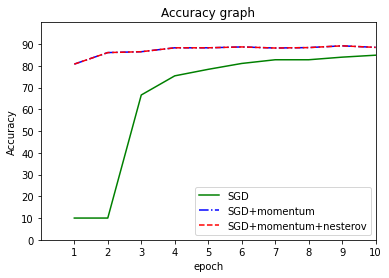

In [14]:
import matplotlib.pyplot as plt
import numpy as np
f = open('result/sgd1.csv')  # 打开csv文件
reader = csv.reader(f)  # 读取csv文件
data1 = list(reader)  # csv数据转换为列表
f.close()

f = open('result/sgd2.csv')  # 打开csv文件
reader = csv.reader(f)  # 读取csv文件
data2 = list(reader)  # csv数据转换为列表
f.close()

f = open('result/sgd3.csv')  # 打开csv文件
reader = csv.reader(f)  # 读取csv文件
data3 = list(reader)  # csv数据转换为列表
f.close()


x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y1 = list()
y2 = list()
y3 = list()
for i in range(1, 11):  # 从第二行开始读取
    y1.append(float(data1[i][0]))
    y2.append(float(data2[i][0]))
    y3.append(float(data2[i][0]))

plt.plot(x, y1, color='g', linestyle='-', label = 'SGD')  
plt.plot(x, y2, color='b', linestyle='-.', label = 'SGD+momentum')
plt.plot(x, y3, color='r', linestyle='--', label = 'SGD+momentum+nesterov')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy graph')
plt.xlim((0, 10))
plt.ylim((0, 100))
my_y_ticks = np.arange(0, 100, 10)
plt.xticks(x)
plt.yticks(my_y_ticks)

plt.legend()
plt.savefig("sgd不同参数精确度对比图.png")
plt.show()  # 显示折线图

这是笔者训练的结果：
![avatar](image/sgd不同参数精确度对比图.png)

对平均损失相关数据进行绘图

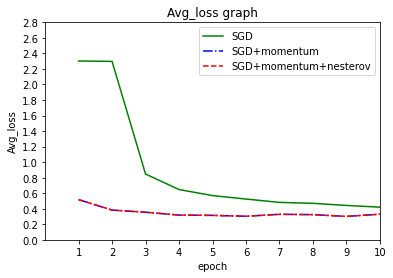

In [15]:
import matplotlib.pyplot as plt
import numpy as np
f = open('result/sgd1.csv')  # 打开csv文件
reader = csv.reader(f)  # 读取csv文件
data1 = list(reader)  # csv数据转换为列表
f.close()

f = open('result/sgd2.csv')  # 打开csv文件
reader = csv.reader(f)  # 读取csv文件
data2 = list(reader)  # csv数据转换为列表
f.close()

f = open('result/sgd3.csv')  # 打开csv文件
reader = csv.reader(f)  # 读取csv文件
data3 = list(reader)  # csv数据转换为列表
f.close()


x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y1 = list()
y2 = list()
y3 = list()
for i in range(1, 11):  # 从第二行开始读取
    y1.append(float(data1[i][1]))
    y2.append(float(data2[i][1]))
    y3.append(float(data2[i][1]))

plt.plot(x, y1, color='g', linestyle='-', label = 'SGD') 
plt.plot(x, y2, color='b', linestyle='-.', label = 'SGD+momentum')
plt.plot(x, y3, color='r', linestyle='--', label = 'SGD+momentum+nesterov')
plt.xlabel('epoch')
plt.ylabel('Avg_loss')
plt.title('Avg_loss graph')
plt.xlim((0, 10))
plt.ylim((0, 2.5))
my_y_ticks = np.arange(0, 3, 0.2)
plt.xticks(x)
plt.yticks(my_y_ticks)

plt.legend()
plt.savefig("sgd不同参数损失对比图.png")
plt.show()  # 显示折线图

这是笔者训练的结果：
![avatar](image/sgd不同参数损失对比图.png)

#### 3.3.2 结果分析

无论是预测精度还是平均损失，纯粹的SGD表现并不是很好。第一个epoch之后，SGD预测精度只有10%，和瞎猜概率差不多，随着迭代次数增加，SGD的预测精度才慢慢增加，平均损失逐渐下降。10个epoch之后，SGD预测精度才不到85%。根据额外的实验，大概20个epoch能收敛到88%左右，这也是用fashion-minist数据集训练lenet所能达到的最高精度。

而使用momentum优化后，算法性能得到了质的飞跃，大概3个epoch就能收敛。

理论上来说，nesterov算法可以有效加速网络训练并减少波动。由于本实验所采用的数据集和网络模型都比较简单，算法优势没能很好的体现出来。





#### 3.3.3 对于优化器选择的一些看法

由上述实验，我们可以得到的结论是，选择SGD优化器，momentum参数是非常有用的。

目前，最流行并且使用很高的优化器包括SGD、RMSprop、AdaDelta和Adam。每种优化器都有不同参数需要调试。在实际应用中，选择哪种优化器应结合具体问题。在充分理解数据的基础上，依然需要根据数据特性、算法特性进行充分的调参实验，找到最优解。

各大算法孰优孰劣并无定论。如果是刚入门，优先考虑SGD+NesteroV Momentum或者Adam（Standford 231n : The two recommended updates to use are either SGD+NesteroV Momentum or Adam）。


## 4 总结

本案例基于MindSpore框架讲解了SGD优化器的基本原理以及几种优化方法，并设计了一个实验，比较SGD优化器几个参数设置带来的影响，顺利完成了预期目标。通过此案例可以进一步加深对SGD优化器的理解，对优化器参数选择有基本的认识，并结合MindSpore框架提供的文档和教程，掌握利用Mindspore框架实现特定案例的流程，以及多种API的使用方法，为以后在实际场景中应用MindSpore框架提供支持。